# HW6: A GRU-pair model for SNLI with attention

In this assignment we'll build and train an attention-based model for SNLI. The model will incorporate the basic word-by-word attention+matching layer design from [Wang and Jiang](https://arxiv.org/pdf/1512.08849v2.pdf), but it will use GRUs instead of LSTMs, and it will use [Luong et al.](http://www.aclweb.org/anthology/D15-1166)'s 'general' bilinear attention scoring function.

Do not start this assignment at the last minute, since the model you build may take several hours to train.

**Note:** Submissions (both late initial submissions and resubmissions) will only be accepted until the evening of 12/16. Resubmission will be open for only a few days, even for students who submit on time.

## Setup

You'll need to download and unzip SNLI, which you can find [here](http://nlp.stanford.edu/projects/snli/). Set `snli_home` below to point to it. The following block of code loads it.

In [2]:
snli_home = '/media/wanghaoran1992/新加卷/Data/SNLI/snli_1.0'

import re
import random
import json

LABEL_MAP = {
    "entailment": 0,
    "neutral": 1,
    "contradiction": 2
}

def load_snli_data(path):
    data = []
    with open(path) as f:
        for line in f:
            loaded_example = json.loads(line)
            if loaded_example["gold_label"] not in LABEL_MAP:
                continue
            loaded_example["label"] = LABEL_MAP[loaded_example["gold_label"]]
            data.append(loaded_example)
        random.seed(1)
        random.shuffle(data)
    return data
     
training_set = load_snli_data(snli_home + '/snli_1.0_train.jsonl')
dev_set = load_snli_data(snli_home + '/snli_1.0_dev.jsonl')
test_set = load_snli_data(snli_home + '/snli_1.0_test.jsonl')

# Note: Unlike with k-nearest neighbors, evaluation here should be fast, and we don't need to
# trim down the dev and test sets. 

Next, we'll convert the data to index vectors in the same way that we've done for in-class exercises with RNN-based sentiment models. A few notes:

- We use a sequence length of only 10, which is short enough that we're truncating a large fraction of sentences.
- Tokenization is easy here because we're relying on the output of a parser (which does tokenization as part of parsing), just as with the SST corpus that we've been using until now. Note that we use the 'sentence1_binary_parse' field of each example rather than the human-readable 'sentence1'.
- We're using a moderately large vocabulary of about 36k words.

In [3]:
SEQ_LEN = 10

import collections
import numpy as np

def sentences_to_padded_index_sequences(datasets):
    '''Annotates datasets with feature vectors.'''
    
    PADDING = "<PAD>"
    UNKNOWN = "<UNK>"
    
    # Extract vocabulary
    def tokenize(string):
        string = re.sub(r'\(|\)', '', string)
        return string.lower().split()
    
    word_counter = collections.Counter()
    for example in datasets[0]:
        word_counter.update(tokenize(example['sentence1_binary_parse']))
        word_counter.update(tokenize(example['sentence2_binary_parse']))
        
    vocabulary = set([word for word in word_counter])
    vocabulary = list(vocabulary)
    vocabulary = [PADDING, UNKNOWN] + vocabulary
        
    word_indices = dict(zip(vocabulary, range(len(vocabulary))))
    indices_to_words = {v: k for k, v in word_indices.items()}
        
    for i, dataset in enumerate(datasets):
        for example in dataset:
            for sentence in ['sentence1_binary_parse', 'sentence2_binary_parse']:
                example[sentence + '_index_sequence'] = np.zeros((SEQ_LEN), dtype=np.int32)

                token_sequence = tokenize(example[sentence])
                padding = SEQ_LEN - len(token_sequence)

                for i in range(SEQ_LEN):
                    if i >= padding:
                        if token_sequence[i - padding] in word_indices:
                            index = word_indices[token_sequence[i - padding]]
                        else:
                            index = word_indices[UNKNOWN]
                    else:
                        index = word_indices[PADDING]
                    example[sentence + '_index_sequence'][i] = index
    return indices_to_words, word_indices
    
indices_to_words, word_indices = sentences_to_padded_index_sequences([training_set, dev_set, test_set])

In [4]:
print training_set[6]
print len(word_indices)

{u'annotator_labels': [u'contradiction'], u'sentence2_parse': u'(ROOT (NP (NP (NNS People)) (PP (IN on) (NP (DT a) (NN bike))) (PP (IN on) (NP (DT a) (NN beach))) (. .)))', u'sentence1_binary_parse': u'( ( Five men ) ( ( are ( ( ( playing ( musical instruments ) ) together ) ( on ( a stage ) ) ) ) . ) )', u'captionID': u'2430018178.jpg#1', 'sentence1_binary_parse_index_sequence': array([ 4427, 35502, 23868,  2606,  7654, 11706, 16853, 30670, 11078,   378], dtype=int32), 'label': 2, u'sentence2_binary_parse': u'( ( ( People ( on ( a bike ) ) ) ( on ( a beach ) ) ) . )', u'pairID': u'2430018178.jpg#1r1c', u'sentence2': u'People on a bike on a beach.', u'sentence1_parse': u'(ROOT (S (NP (CD Five) (NNS men)) (VP (VBP are) (VP (VBG playing) (NP (JJ musical) (NNS instruments)) (ADVP (RB together)) (PP (IN on) (NP (DT a) (NN stage))))) (. .)))', 'sentence2_binary_parse_index_sequence': array([    0,     0,  9336, 16853, 30670, 20331, 16853, 30670, 20428,   378], dtype=int32), u'gold_label': u

Now we load GloVe. You'll need the same file that you used for the in-class exercise on word embeddings.

In [5]:
glove_home = '/media/wanghaoran1992/新加卷/Data/Glove/glove.6B/'
words_to_load = 50000

with open(glove_home + 'glove.6B.50d.txt') as f:
    loaded_embeddings = np.zeros((len(word_indices), 50), dtype='float32')
    for i, line in enumerate(f):
        if i >= words_to_load: 
            break
        
        s = line.split()
        if s[0] in word_indices:
            loaded_embeddings[word_indices[s[0]], :] = np.asarray(s[1:])

Now we set up an evaluation function as before.

In [6]:
def evaluate_classifier(classifier, eval_set):
    correct = 0
    hypotheses = classifier(eval_set)
    for i, example in enumerate(eval_set):
        hypothesis = hypotheses[i]
        if hypothesis == example['label']:
            correct += 1        
    return correct / float(len(eval_set))

## Part 1: Implementation (70%)

Expand the below starter code to build a working attention-based NLI model. The model should feature the following:

- 50D word embeddings initialized with GloVe and trained. (Using self.E should provide this.)
- Three GRUs (with two different sets of parameters): a premise encoder, a hypothesis encoder (sharing the same parameters), and matching GRU, taking the place of [Wang and Jiang](https://arxiv.org/pdf/1512.08849v2.pdf)'s mLSTM, with its own parameters. There shouldn't be a connection between the premise and hypothesis GRUs: the starting hidden state for each of the three GRUs should be zeros.
- Word-by-word attention using [Luong et al.](http://www.aclweb.org/anthology/D15-1166)'s 'general' (bilinear) scoring function.
- A three-way softmax classifier whose input is the final hidden state of the matching RNN.

As ever, do not use any other pre-written code or TF functions that are specific to RNNs or attention.


As in class, the below line may give you a warning. It should be safe to ignore.

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

In [8]:
import tensorflow as tf

In [23]:
class RNNEntailmentClassifier:
    def __init__(self, vocab_size, sequence_length):
        # Define the hyperparameters
        self.training_epochs = 30  # How long to train for - chosen to fit within class time
        self.display_epoch_freq = 1  # How often to print cost (in epochs)
        self.display_step_freq = 250  # How often to test (in steps)
        self.dim = 24  # The dimension of the hidden state of each RNN
        self.embedding_dim = 50  # The dimension of the learned word embeddings
        self.batch_size = 64  # Somewhat arbitrary - can be tuned, but often tune for speed, not accuracy
        self.vocab_size = vocab_size  # Defined by the file reader above
        self.sequence_length = sequence_length  # Defined by the file reader above
        
        # Define the parameters
        self.E = tf.Variable(loaded_embeddings, trainable=False)
        
        # parameters for attention
        self.W_a = tf.Variable(tf.random_normal([self.dim, self.dim],stddev = 0.1))
        
        self.W_cl = tf.Variable(tf.random_normal([self.dim, 3], stddev=0.1))
        self.b_cl = tf.Variable(tf.random_normal([3], stddev=0.1))

        # two set of parameters
        in_dim = self.embedding_dim
            
        self.W_rnn = tf.Variable(tf.random_normal([in_dim + self.dim, self.dim], stddev=0.1))
        self.b_rnn = tf.Variable(tf.random_normal([self.dim], stddev=0.1))

        self.W_r = tf.Variable(tf.random_normal([in_dim + self.dim, self.dim], stddev=0.1))
        self.b_r = tf.Variable(tf.random_normal([self.dim], stddev=0.1))

        self.W_z = tf.Variable(tf.random_normal([in_dim + self.dim, self.dim], stddev=0.1))
        self.b_z = tf.Variable(tf.random_normal([self.dim], stddev=0.1))
        
        
        self.W_rnn_matching = tf.Variable(tf.random_normal([3*self.dim, self.dim], stddev=0.1))
        self.b_rnn_matching = tf.Variable(tf.random_normal([self.dim], stddev=0.1))

        self.W_r_matching = tf.Variable(tf.random_normal([3*self.dim, self.dim], stddev=0.1))
        self.b_r_matching = tf.Variable(tf.random_normal([self.dim], stddev=0.1))

        self.W_z_matching = tf.Variable(tf.random_normal([3*self.dim, self.dim], stddev=0.1))
        self.b_z_matching = tf.Variable(tf.random_normal([self.dim], stddev=0.1))
        
            
        # Define the placeholders
        self.premise_x = tf.placeholder(tf.int32, [None, self.sequence_length])
        self.hypothesis_x = tf.placeholder(tf.int32, [None, self.sequence_length])
        self.y = tf.placeholder(tf.int32, [None])
        
        # Define the model
        # the gru step
        def gru_step(emb, h_prev):
            emb_h_prev = tf.concat(1, [emb, h_prev])
            z = tf.nn.sigmoid(tf.matmul(emb_h_prev, self.W_z) + self.b_z)
            r = tf.nn.sigmoid(tf.matmul(emb_h_prev, self.W_r) + self.b_r)
            emb_r_h_prev = tf.concat(1, [emb, r * h_prev])
            h_tilde = tf.nn.tanh(tf.matmul(emb_r_h_prev, self.W_rnn) + self.b_rnn)
            h = (1. -z) * h_prev + z * h_tilde
            return h
        
        def matching_gru_step(m, h_prev):
            m_h_prev = tf.concat(1, [m, h_prev])
            z = tf.nn.sigmoid(tf.matmul(m_h_prev, self.W_z_matching) + self.b_z_matching)
            r = tf.nn.sigmoid(tf.matmul(m_h_prev, self.W_r_matching) + self.b_r_matching)
            m_r_h_prev = tf.concat(1, [m, r * h_prev])
            h_tilde = tf.nn.tanh(tf.matmul(m_r_h_prev, self.W_rnn_matching) + self.b_rnn_matching)
            h = (1. -z) * h_prev + z * h_tilde
            return h

        # Define one step of the premise GRU
        def premise_step(x, h_prev):
            emb = tf.nn.embedding_lookup(self.E, x)
            return gru_step(emb, h_prev)
        
        # Define one step of the hypothesis GRU
        def hypothesis_step(x, h_prev):
            emb = tf.nn.embedding_lookup(self.E, x)
            return gru_step(emb, h_prev)
        
        # Split up the inputs into individual tensors
        self.x_premise_slices = tf.split(1, self.sequence_length, self.premise_x)
        self.x_hypothesis_slices = tf.split(1, self.sequence_length, self.hypothesis_x)
        
        self.h_zero = tf.zeros(tf.pack([tf.shape(self.premise_x)[0], self.dim]))
        
        # Unroll the first GRU
        premise_h_prev = self.h_zero
        premise_steps_list = []

        for t in range(self.sequence_length):
            x_t = tf.reshape(self.x_premise_slices[t], [-1])
            premise_h_prev = premise_step(x_t, premise_h_prev)
            premise_steps_list.append(premise_h_prev)
            
        premise_steps = tf.pack(premise_steps_list, axis=1)
 
        # Unroll the second GRU
        hypothesis_h_prev = self.h_zero
        hypothesis_steps_list = []
        
        for t in range(self.sequence_length):
            x_t = tf.reshape(self.x_hypothesis_slices[t], [-1])
            hypothesis_h_prev = hypothesis_step(x_t, hypothesis_h_prev)
            hypothesis_steps_list.append(hypothesis_h_prev)
        
        # Attention and the matching GRU
        self.complete_attn_weights = []
        match_h_previous = tf.zeros([tf.shape(self.premise_x)[0], self.dim])
        for t in range(self.sequence_length):
            wm_list = []
            hypothesis_hidden = hypothesis_steps_list[t]
            for i in range(len(premise_steps_list)):
                premise_hidden = premise_steps_list[i]
                w = tf.reduce_sum(tf.mul(tf.matmul(hypothesis_hidden, self.W_a), premise_hidden),1, keep_dims = True)
                wm_list.append(w)
            wm = tf.pack(wm_list, axis=1)        
            attn_weights = tf.nn.softmax(wm, dim=1)
            self.complete_attn_weights.append(tf.reshape(attn_weights,[tf.shape(self.premise_x)[0], self.sequence_length]))
            intermediate_a = tf.mul(attn_weights, premise_steps)
            a = tf.reduce_sum(intermediate_a, 1)
            m = tf.concat(1, [hypothesis_hidden, a])
            match_h_previous = matching_gru_step(m, match_h_previous)
        self.complete_attn_weights = tf.pack(self.complete_attn_weights, axis = 2)
        
        # Compute the logits
        self.logits = tf.matmul(match_h_previous, self.W_cl) + self.b_cl
        
        # Define the cost function (here, the softmax exp and sum are built in)
        self.total_cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(self.logits, self.y))
        
        # This  performs the main SGD update equation with gradient clipping
        optimizer_obj = tf.train.AdamOptimizer()
        gvs = optimizer_obj.compute_gradients(self.total_cost)
        capped_gvs = [(tf.clip_by_norm(grad, 5.0), var) for grad, var in gvs if grad is not None]
        self.optimizer = optimizer_obj.apply_gradients(capped_gvs)
        
        # Create an operation to fill zero values in for W and b
        self.init = tf.initialize_all_variables()

        # Create a placeholder for the session that will be shared between training and evaluation
        self.sess = tf.Session()
        
        # Initialize variables
        self.sess.run(self.init)
        self.step = 1
        self.epoch = 0
        
    def train(self, training_data, dev_data):
        def get_minibatch(dataset, start_index, end_index):
            indices = range(start_index, end_index)
            premise_vectors = np.vstack([dataset[i]['sentence1_binary_parse_index_sequence'] for i in indices])
            hypothesis_vectors = np.vstack([dataset[i]['sentence2_binary_parse_index_sequence'] for i in indices])
            labels = [dataset[i]['label'] for i in indices]
            return premise_vectors, hypothesis_vectors, labels

        print 'Training.'

        # Training cycle
        for _ in range(self.training_epochs):
            random.shuffle(training_data)
            avg_cost = 0.
            total_batch = int(len(training_data) / self.batch_size)
            
            # Loop over all batches in epoch
            for i in range(total_batch):
                # Assemble a minibatch of the next B examples
                minibatch_premise_vectors, minibatch_hypothesis_vectors, minibatch_labels = get_minibatch(
                    training_data, self.batch_size * i, self.batch_size * (i + 1))

                # Run the optimizer to take a gradient step, and also fetch the value of the 
                # cost function for logging
                _, c = self.sess.run(
                     [self.optimizer, self.total_cost], 
                     feed_dict={self.premise_x: minibatch_premise_vectors,
                                self.hypothesis_x: minibatch_hypothesis_vectors,
                                self.y: minibatch_labels})

                if self.step % self.display_step_freq == 0:
                    print "Step:", self.step, "Dev acc:", evaluate_classifier(self.classify, dev_data[0:1000]), \
                        "Train acc:", evaluate_classifier(self.classify, training_data[0:1000]) 
                                  
                self.step += 1
                avg_cost += c / (total_batch * self.batch_size)
                                
            # Display some statistics about the step
            # Evaluating only one batch worth of data
            if self.epoch % self.display_epoch_freq == 0:
                print "Epoch:", (self.epoch + 1), "Cost:", avg_cost 
            self.epoch += 1
    
    def classify(self, examples):
        # This classifies a list of examples
        premise_vectors = np.vstack([example['sentence1_binary_parse_index_sequence'] for example in examples])
        hypothesis_vectors = np.vstack([example['sentence2_binary_parse_index_sequence'] for example in examples])
        logits = self.sess.run(self.logits,
                               feed_dict={self.premise_x: premise_vectors,
                                          self.hypothesis_x: hypothesis_vectors})

        return np.argmax(logits, axis=1)

    def get_attn(self, examples):
        premise_vectors = np.vstack([example['sentence1_binary_parse_index_sequence'] for example in examples])
        hypothesis_vectors = np.vstack([example['sentence2_binary_parse_index_sequence'] for example in examples])
        attn_weights = self.sess.run(self.complete_attn_weights, 
                                     feed_dict={self.premise_x: premise_vectors,
                                                self.hypothesis_x: hypothesis_vectors})
        return np.reshape(attn_weights, [len(examples), 10, 10])
        
    def plot_attn(self, examples):
        attn_weights = self.get_attn(examples)

        for i in range(len(examples)):    
            fig = plt.figure()
            ax = fig.add_subplot(111)
            ax.matshow(attn_weights[i,:,:], vmin=0., vmax=1., cmap=plt.cm.inferno)

            premise_tokens = [indices_to_words[index] for index in examples[i]['sentence1_binary_parse_index_sequence']]
            hypothesis_tokens = [indices_to_words[index] for index in examples[i]['sentence2_binary_parse_index_sequence']]

            ax.set_yticklabels(premise_tokens)
            ax.set_xticklabels(hypothesis_tokens, rotation=45)

            plt.xticks(np.arange(0, 10, 1.0))
            plt.yticks(np.arange(0, 10, 1.0))

This creates a classifier and initializes it. Note that starting and stopping training will not re-initialize the model.

In [24]:
classifier = RNNEntailmentClassifier(len(word_indices), SEQ_LEN)

Running this line tests that you've successfully avoided a common error in implementing attention: mixing up dimensions in a way that allows information about one example in a batch to impact the results for other examples. It should do nothing if the model behaves correctly, and will throw an error otherwise.

In [26]:
assert (classifier.get_attn(training_set[0:2])[0, :, :] == \
        classifier.get_attn(training_set[0:3])[0, :, :]).all(), \
       'Warning: There is cross-example information flow.'

Run the model below. Your goal is dev set performance above 74% at at least a few steps within the first 30 epochs. This may require running your model overnight, though it won't necessarily require running for all 30 epochs. Since a single epoch can take a long time with this model, you'll see accuracy results every 250 steps rather than every epoch.

In [28]:
classifier.train(training_set, dev_set)

Training.
Step: 250 Dev acc: 0.511 Train acc: 0.502
Step: 500 Dev acc: 0.545 Train acc: 0.543
Step: 750 Dev acc: 0.569 Train acc: 0.567
Step: 1000 Dev acc: 0.58 Train acc: 0.569
Step: 1250 Dev acc: 0.595 Train acc: 0.561
Step: 1500 Dev acc: 0.585 Train acc: 0.576
Step: 1750 Dev acc: 0.593 Train acc: 0.579
Step: 2000 Dev acc: 0.6 Train acc: 0.578
Step: 2250 Dev acc: 0.617 Train acc: 0.593
Step: 2500 Dev acc: 0.637 Train acc: 0.594
Step: 2750 Dev acc: 0.613 Train acc: 0.595
Step: 3000 Dev acc: 0.64 Train acc: 0.598
Step: 3250 Dev acc: 0.626 Train acc: 0.605
Step: 3500 Dev acc: 0.644 Train acc: 0.607
Step: 3750 Dev acc: 0.643 Train acc: 0.607
Step: 4000 Dev acc: 0.66 Train acc: 0.603
Step: 4250 Dev acc: 0.646 Train acc: 0.591
Step: 4500 Dev acc: 0.656 Train acc: 0.614
Step: 4750 Dev acc: 0.652 Train acc: 0.618
Step: 5000 Dev acc: 0.659 Train acc: 0.634
Step: 5250 Dev acc: 0.661 Train acc: 0.613
Step: 5500 Dev acc: 0.668 Train acc: 0.624
Step: 5750 Dev acc: 0.666 Train acc: 0.626
Step: 600

KeyboardInterrupt: 

This will print some (NYU-colored) visualizations for the first ten training examples. It should be useful in the questions below.

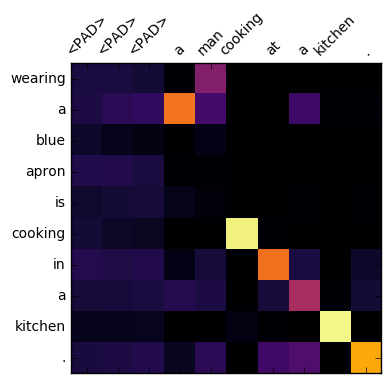

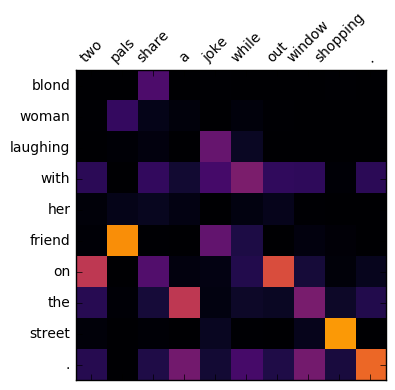

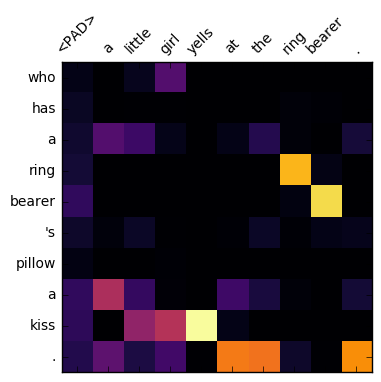

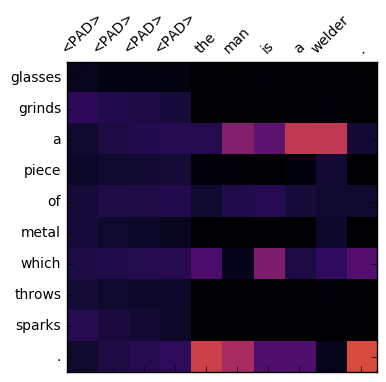

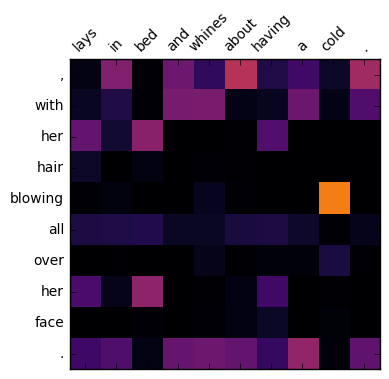

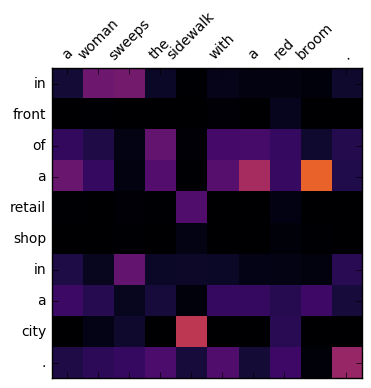

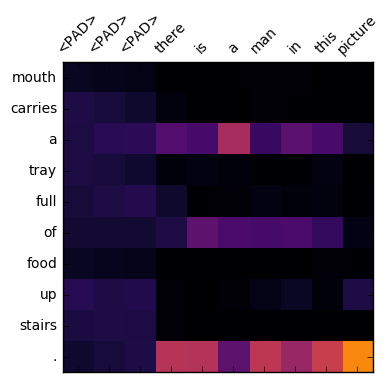

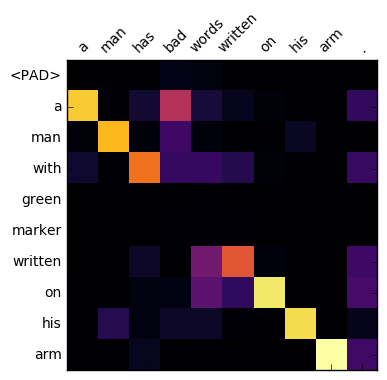

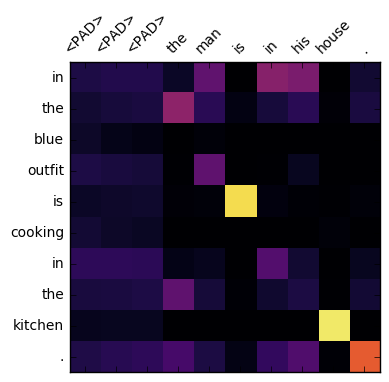

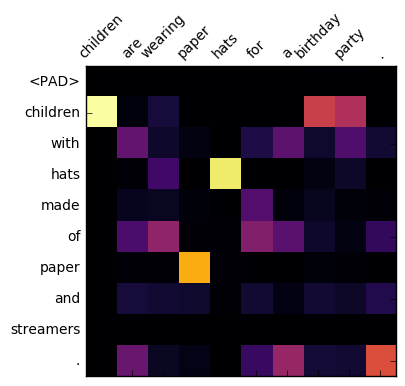

In [29]:
classifier.plot_attn(training_set[0:10])

## Part 2: Questions (30%)

**Question 1:** Consider a version of our model that discards the attention scoring function, and instead always allocates all of its attention on a single word, where that single word is selected by a simple strategy that does not depend on the contents of the hypothesis sentence. With the right such strategy, this version of our model would still be able to learn to solve NLI well (i.e., with better than 80% dev accuracy), though we might need to use larger hidden states in our GRU. What simple strategy would we need to use and why?

**Answer:** We can just select the subject of the premise to be the word. We can still achieve a high accuracy because the relationship between subjects of premise and hypothesis indicates the relationship between the two sentences. 

**Question 2:** Looking at a visualization like the ones generated above, it is usually possible to identify which axis contains the hypothesis words and which axis contains the premise words. This is possible even if you look only at the plot itself and disregard the words. What property of the plot allows you do this? Under what circumstances would such a strategy fail to give you an answer?

**Answer:** The weights of a given word in a hypothesis sentence sum up to 1, but the weights of a premise word do not. So if we see from the plot that multiple large weights appear for some word, then it's likely that this word is in the premise sentence. Or if we see there is very small sum of weights for some word, then we can speculate that it's also in the premise sentence because the weighs of a hypothesis word has to sum up to 1.

However, if the two sentences are very close to each other and the there is almost one-to-one alignment between the two sentences, this stragegy will fail to give an answer because we cannot see if the sum of weights of a given word is clearly larger than 1 or below 1.

**Question 3:** Using the visualization tool above, and any additional evaluation tools you find useful, show one example each of a case where...
  - ...the model uses attention in a reasonable way and gets a correct answer.
  - ...the model uses attention in an unreasonable/unhelpful way, but gets a correct answer anyway.
  - ...the model uses attention in a reasonable way, but gets an incorrect answer.
  - ...the model uses attention in an unreasonable/unhelpful way and gets an incorrect answer.
  
You should make sure that these four examples are displayed one after another, and you should include some commentary on what role you think attention might be playing in each decision.

The true label:1
Predicted label: [1]


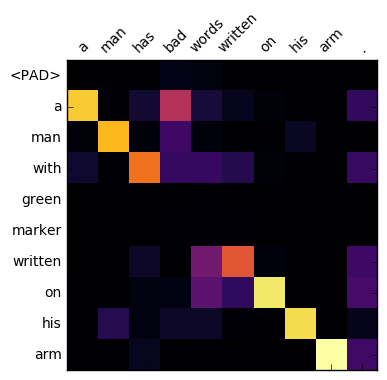

In [40]:
def analysis(example):
    print "The true label:" + str(example[0]['label'])
    print "Predicted label: " + str(classifier.classify(example))
    classifier.plot_attn(example)

analysis([training_set[7]])

From the result above, we see that the model uses attention in a reasonable way and gets a correct answer. In this case, attention makes a good alignment between words of hypothesis and premise so the matching layer can well encode the information between attention and hypythesis hidden state and make a good prediction.

The true label:2
Predicted label: [2]


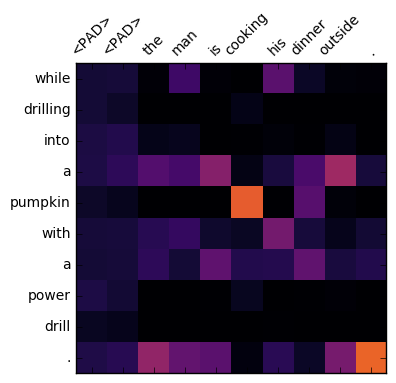

In [54]:
analysis([training_set[17]])

For this sentence, the model uses attention in an unhelpful way but still gets a correct answer. The alignment between words in the two sentences is not so close that words can be matched with each other. So in this case the attention didn't help too much but the model still gets the right answer.

The true label:1
Predicted label: [0]


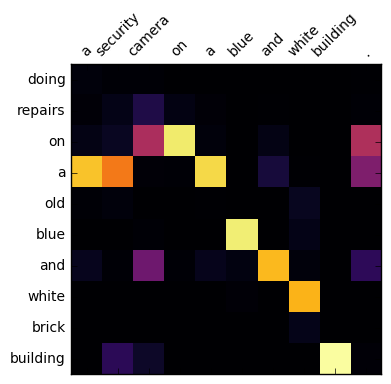

In [53]:
analysis([training_set[15]])

Here, the model uses attention in a reasonable way but gets an incorrect answer. We see that words of hypothesis and premise are aligned with each other pretty well because of attention mechanism but we still get a wrong answer. One possible issue might be that we are limiting the sequence length to be 10 so some important information is needed in order to accurately predict the relationship between the two.

The true label:2
Predicted label: [1]


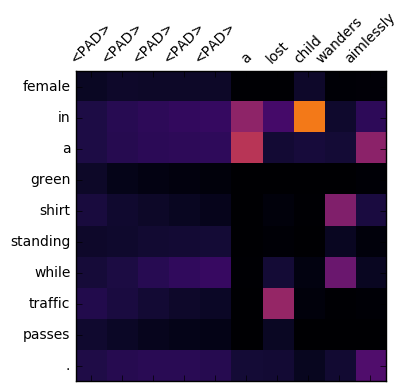

In [47]:
analysis([training_set[12]])

Lastly, the model uses attention in an unreasonable way and gets an incorrect answer. Here we see that there is not a clear alignment between the two sentences given by the attention. The biggest weight is between "child" and "in", which seems unhelpful. And our model gave a wrong prediction for this example.